In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [356]:
data = pd.DataFrame.from_csv("./orders.csv",index_col=None)

data[:10]

,cancel_time,dist,driver_found,due,f_class,lat,lon,s_class,t_class
0,-1,17466.814282,False,2014-01-01 00:15:00.000,econom,55.861125,37.468335,NaN,NaN
1,-1,19200.533178,True,2014-01-01 00:15:00.000,econom,55.872102,37.672998,NaN,NaN
2,-1,19406.264026,True,2014-01-01 00:14:59.000,econom,55.899335,37.584883,NaN,NaN
3,-1,7384.500873,True,2014-01-01 00:15:00.000,econom,55.749035,37.657377,business,NaN
4,347,18475.892895,False,2014-01-01 00:30:00.000,econom,55.765954,37.609119,NaN,NaN
5,-1,-1.000000,True,2014-01-01 01:00:00.000,econom,55.541556,37.448638,NaN,NaN
6,-1,16756.166625,True,2014-01-01 00:15:00.000,econom,55.886539,37.589105,NaN,NaN
7,-1,1267.743236,True,2014-01-01 00:15:00.000,econom,55.782572,37.531936,business,NaN
8,117,8540.243014,True,2014-01-01 00:30:00.000,econom,55.721265,37.623196,business,NaN
9,632,4905.943311,False,2014-01-01 00:15:00.000,econom,51.668344,39.207752,business,NaN


In [318]:
data["burned"] = data["cancel_time"]>40 | (~data["driver_found"])

In [3]:
df = data.irow(np.random.randint(0,len(data),10000))

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: FutureWarning: irow(i) is deprecated. Please use .iloc[i]
  if __name__ == '__main__':


In [354]:
df.describe()

,cancel_time,dist,driver_found,lat,lon
count,10000.000000,10000.000000,10000,10000.000000,10000.000000
mean,355.043600,13648.460016,0.9505,55.872363,37.373465
std,7962.631591,145105.715779,0.21692,0.819991,1.399387
min,-1.000000,-1.000000,False,37.433978,29.965875
25%,-1.000000,3636.000083,1,55.709128,37.512425
50%,-1.000000,8299.012457,1,55.755621,37.587153
75%,-1.000000,14333.979656,1,55.794844,37.644026
max,732971.000000,10212292.523721,True,60.200422,55.740024


# parse time

In [ ]:
from dateutil import parser
#datetimes = list(data.due.apply(lambda x: parser.parse(x)))

rel_times = map(lambda dt: (dt.hour*60 + dt.minute)/(24.*60), datetimes)

week_days = map( lambda x: x.isoweekday() , datetimes)

ord_days = map( lambda x: x.toordinal() , datetimes)

ord_days = np.array(ord_days)
rel_times = np.array(rel_times)
week_days = np.array(week_days)

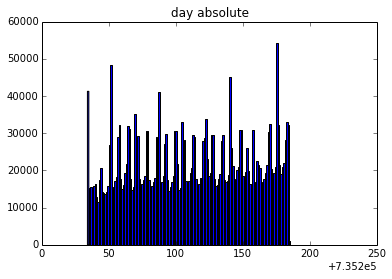

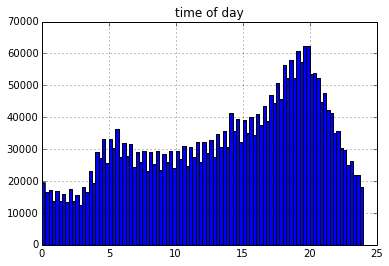

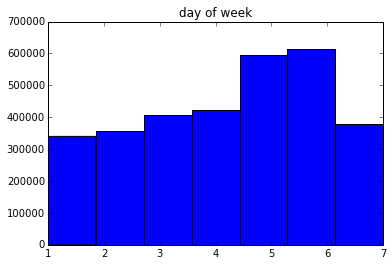

In [339]:
_=plt.hist(ord_days,bins=200)
plt.title('day absolute')
plt.show()
plt.title('time of day')
_=plt.hist(rel_times*24,bins=24*4)
plt.grid()

plt.show()
plt.title('day of week')
_=plt.hist(week_days,bins=7)

In [341]:
data["time_of_day"] = rel_times
data["day_of_week"] = week_days
data["day_abs"] = ord_days

In [343]:
data.to_csv("data_full.csv")

In [348]:
np.unique(df.f_class)

array([nan, 'business', 'econom', 'vip'], dtype=object)

In [349]:
from sklearn.cross_validation import train_test_split

train,test = train_test_split(data,test_size=0.3)

train.to_csv("train_full.csv")
test.to_csv("test_full.csv")


# plotz

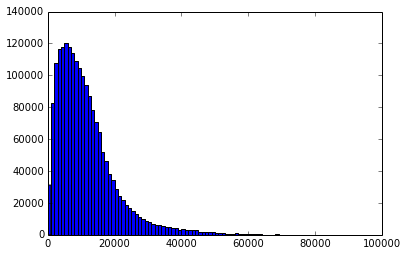

In [350]:
_=plt.hist(train.dist.values,range=[0,100000],bins=100)


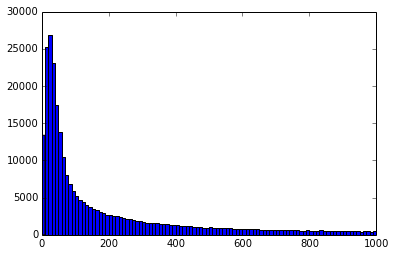

In [353]:
_=plt.hist(train.cancel_time.values,range=[0,1000],bins=100)


In [ ]:
_=plt.hist(train.cancel_time.values,range=[0,1000],bins=100)


# baseline


In [357]:
from sklearn.cross_validation import train_test_split


orders = data[["lon","lat"]].values[:100000]

Xtr, Xts = train_test_split(orders,test_size = 0.5,random_state=32)



In [358]:
lat_w = 0.05
lon_w = 0.05
temp_w = 0.1

In [359]:

grid_lat = (Xtr[0]/lat_w).astype(int)
grid_lon = (Xtr[1]/lon_w).astype(int)
grid_time = 

# naive

In [162]:
from sklearn.mixture import  GMM
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split


orders = data[["lon","lat"]].values[:100000]

Xtr, Xts = train_test_split(orders,test_size = 0.5,random_state=32)

kmeans = KMeans(n_clusters=500,n_init=10,n_jobs=-1)

kmeans.fit(Xtr)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=500, n_init=10,
    n_jobs=-1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [227]:
gmm = GMM(n_components=500,params='wc',init_params='wc',covariance_type= 'spherical' )
#pseudo-fit

gmm.means_ = kmeans.cluster_centers_

gmm.fit(Xtr)
assert np.allclose(kmeans.cluster_centers_ , gmm.means_)

In [228]:
#dare you say i should use sum()? 
train_llh = gmm.score(Xtr).mean()
test_llh =  gmm.score(Xts).mean()
print train_llh,test_llh

1.47687124098 1.46423756693


In [229]:
#remove zero clusters
real_clusters = gmm.weights_>10**-7
gmm.weights_ = gmm.weights_[real_clusters]
gmm.means_ = gmm.means_[real_clusters]
gmm.covars_ = gmm.covars_[real_clusters]
(~real_clusters).sum()

36

5

<matplotlib.colorbar.Colorbar instance at 0x7f6821679758>

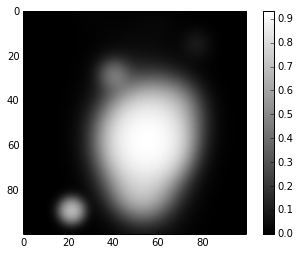

In [230]:
xgrid = np.linspace(37,38,100)
ygrid = np.linspace(55.2,56.2,100)

from itertools import product

grid = product(xgrid,ygrid)
grid = np.array(list(grid))


from scipy.special import expit

pdf = expit( gmm.score(grid))

plt.imshow(pdf.reshape(-1,100),cmap='gray')
plt.colorbar()

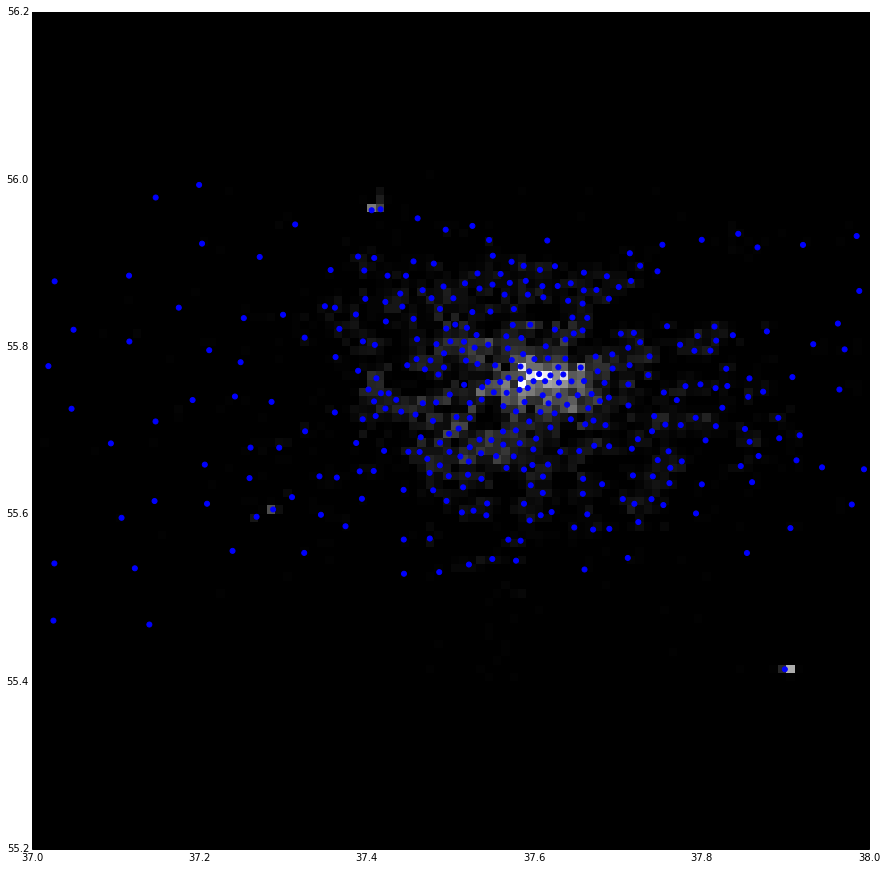

In [231]:

centers = gmm.means_
plt.figure(figsize=[15,15])
_=plt.hist2d(df.lon,df.lat,range=[(37,38),(55.2,56.2)],bins=[100,100],cmap='gray')
plt.scatter(centers[:,0],centers[:,1],marker='.',s=100,color='blue')

(55, 57)

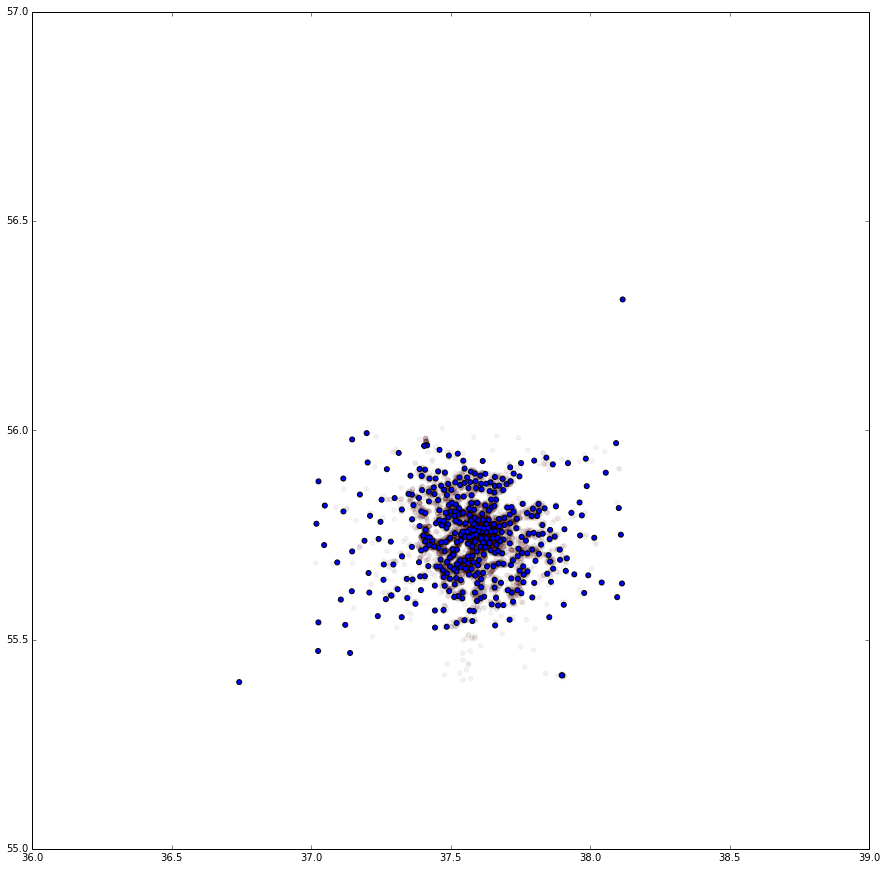

In [234]:
plt.figure(figsize=[15,15])


plt.scatter(df.lon,df.lat, c = df.driver_found,alpha = 0.05)
plt.scatter(gmm.means_[:,0],gmm.means_[:,1],marker='.',s=100)


plt.xlim(36,39)
plt.ylim(55,57)

# time


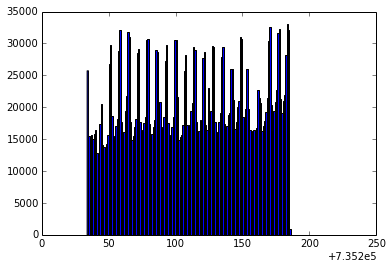

In [261]:
_=plt.hist(ord_days,bins=212)

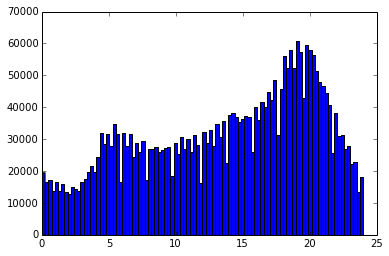

In [262]:
_=plt.hist(rel_times*24,bins=100)

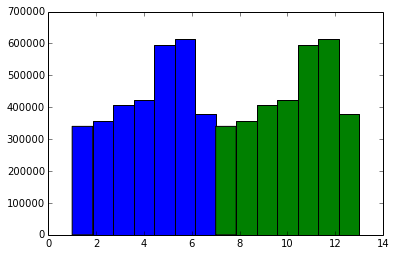

In [265]:
_=plt.hist(week_days,bins=7)
_=plt.hist(week_days+6,bins=7)

In [ ]:
time.isoweekday()

# координаты городов

In [267]:
#city coordinates
moscow = [55.7500, 37.6167]
pburg = [59.9500, 30.3000]


In [271]:
with open("./cities.txt",'w') as f:
    f.write(s)

In [272]:
lines = s.split('\n')[1:-1]

In [273]:
deg = "\xc2\xb0"


rows = []
for line in  lines:
    sname,sloc = line.split('\t')
    
    while sname.startswith(' '): sname = sname[1:]
    while sname.endswith(' '): sname= sname[:-1]
    
    slat,slon = sloc[:-6].split('с.ш.')
    
    lat_deg = int(slat[:slat.index(deg)])
    lat_min = int(slat[slat.index(deg)+2:-2])
    lat = lat_deg+lat_min/60.
    
    lon_deg = int(slon[:slon.index(deg)])
    lon_min = int(slon[slon.index(deg)+2:-2])
    lon = lon_deg+lon_min/60.

    rows.append([sname,lat,lon])
    
    
cities = pd.DataFrame(rows,columns=["name","lat","lon"])

In [304]:
cities.to_csv("cities.csv")

In [303]:
min_dist = np.zeros_like(cities.name)
for i,(city,lat,lon) in cities.iterrows():
    
    dist = np.sqrt((data.lat - lat)**2 +  (data.lon-lon)**2)
    
    dist = np.sort(dist)
    
    min_dist[i]= dist[10]

In [307]:
active_cities = cities[min_dist<0.01]

In [315]:
active_cities

,name,lat,lon
0,Москва,55.750000,37.616667
1,Санкт-Петербург,59.933333,30.316667
6,Казань,55.783333,49.166667
12,Воронеж,51.716667,39.266667
85,Зеленоград,55.933333,37.283333
91,Подольск,55.433333,37.566667
105,Люберцы,55.666667,37.950000
109,Мытищи,55.900000,37.750000
123,Химки,55.883333,37.433333
124,Балашиха,55.833333,37.950000


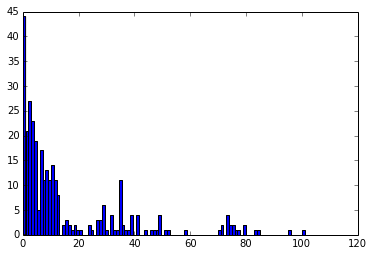

In [311]:
_=plt.hist(min_dist,bins=100)

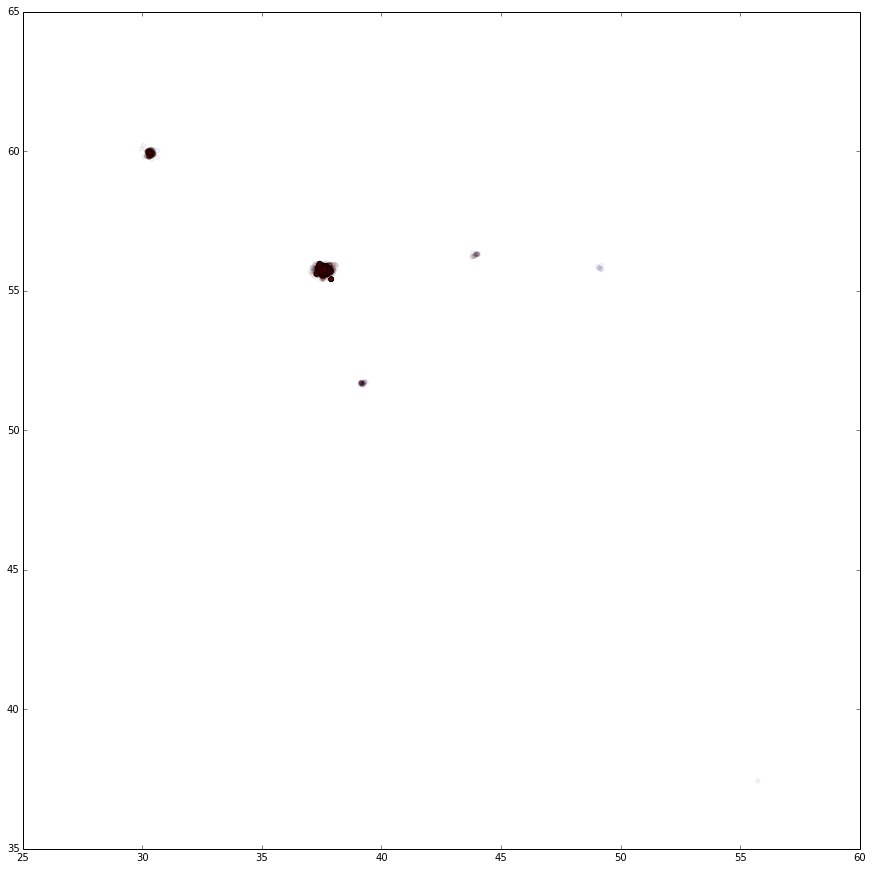

In [313]:
plt.figure(figsize=[15,15])
plt.scatter(df.lon,df.lat, c = df.driver_found,alpha = 0.05)

#plt.xlim(36,39)
#plt.ylim(55,57)